In [41]:
# importing all the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlb
from imblearn.over_sampling import SMOTE 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, precision_recall_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


In [2]:
data = pd.read_csv("stroke prediction.csv")
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# ***Exploratory Data Analysis (EDA)***

### 1.Univariate EDA 

In [3]:
data.shape

(5110, 12)

In [4]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [5]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

BMI column has some outliers. Since they are not many, I wil replace them using the mean.

I will first check the mean amd mode in the column, then decide which one to use.

In [6]:
print('Mean = ', data['bmi'].mean())

print('Mode = ', data['bmi'].mode())

Mean =  28.893236911794666
Mode =  0    28.7
Name: bmi, dtype: float64


Since the Mean and Mode are almost equal, I will use the mean for this exercise.

In [7]:
# Replacing the empty cells using the mean.
data['bmi'].fillna(data['bmi'].mean(), inplace=True)

In [8]:
# Checking for null values in the Dataset.
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

The null cells have been replaced using the mean. In the next lines of code below,  I will ***check and replace the outliers*** in the ***BMI*** and ***AVG_GLUCOSE_LEVEL*** columns.

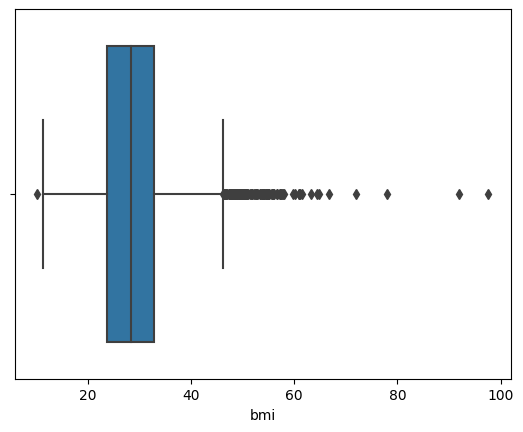

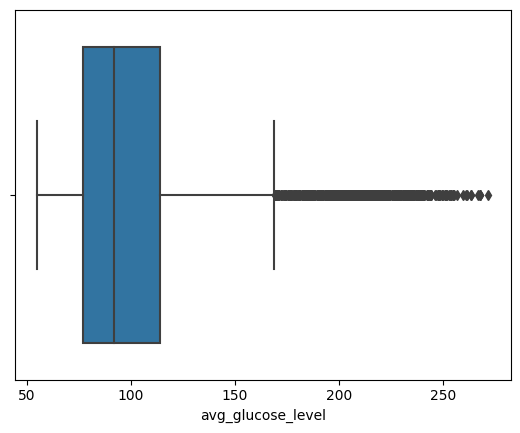

In [9]:
c  = ['bmi', 'avg_glucose_level']

for i in c:
    if i in data.columns:
        plt.show()
        sns.boxplot(data=data, x = i)


Both columns seem to have some outliers. As a result, I will replace them using:
* ***MEAN*** for BMI column
* ***Average for Mean and Mode*** in the ***avg_glucose_level*** column.

In [10]:
# The code below replaces any values > 43 and < 12 with the mean of the BMI column. 

data['bmi'] = np.where(
    data['bmi'] > 43,
    data['bmi'].mean(),
    np.where(
        data['bmi'] < 12,
        data['bmi'].mean(),
        data['bmi']
    )
)

<AxesSubplot: xlabel='bmi'>

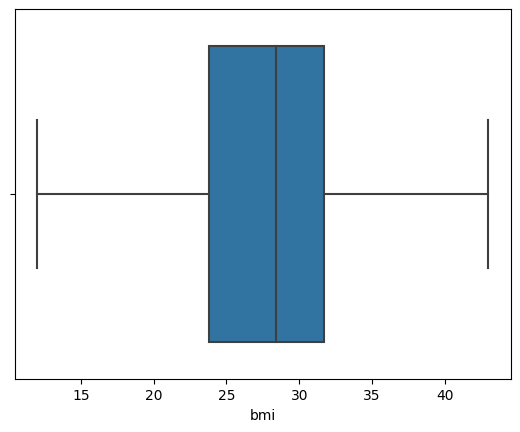

In [11]:
sns.boxplot(x= data.bmi)

From the above Boxplot, it is clear that the column does not contain the outliers anymore.

In [12]:
# Calculating the average for mean and mode of the avg_glucose_level column.

avg = (data['avg_glucose_level'].mean() + data['avg_glucose_level'].mode())/2

# Replacing all values greater than 170 in the avg_glucose_level with the average for mean and mode of the column.

data['avg_glucose_level'] = np.where(
    data['avg_glucose_level'] > 170,
    avg,
    data['avg_glucose_level']
)

<AxesSubplot: xlabel='avg_glucose_level'>

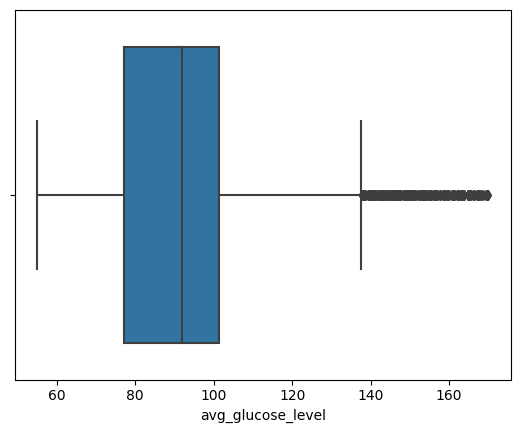

In [13]:
sns.boxplot(data=data, x = 'avg_glucose_level')

Though some outliers cropped up after handling them for the first time, I will live it at that point to avoid interferig with the original Dataset too much.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


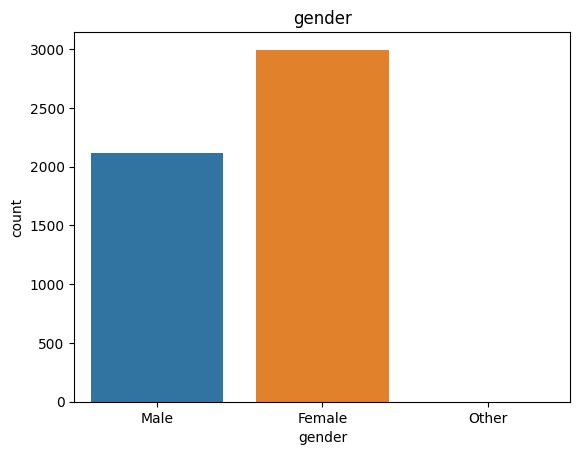

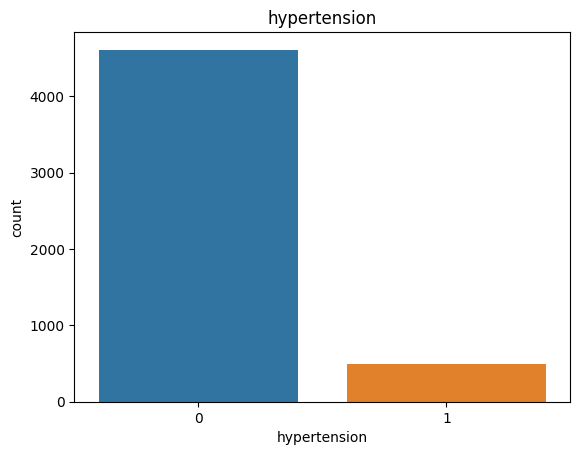

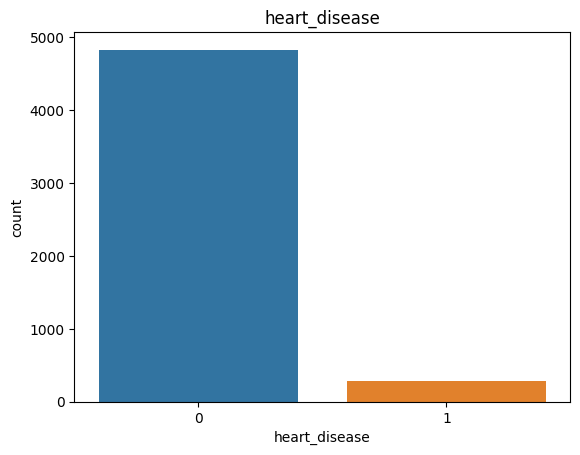

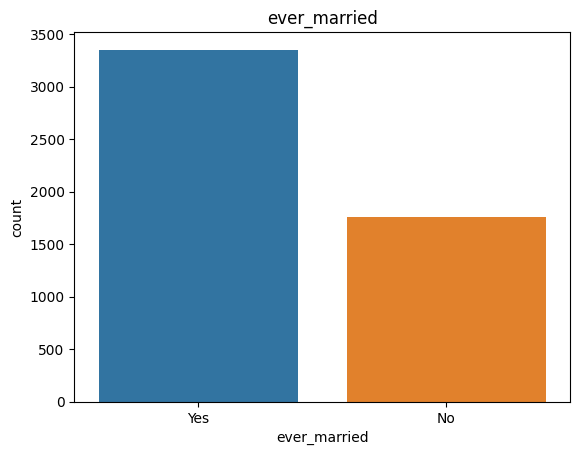

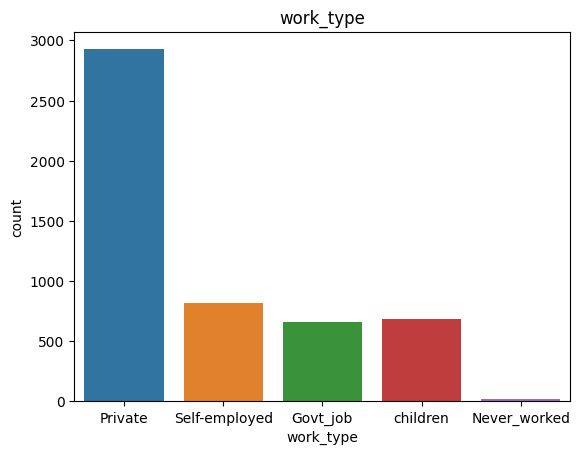

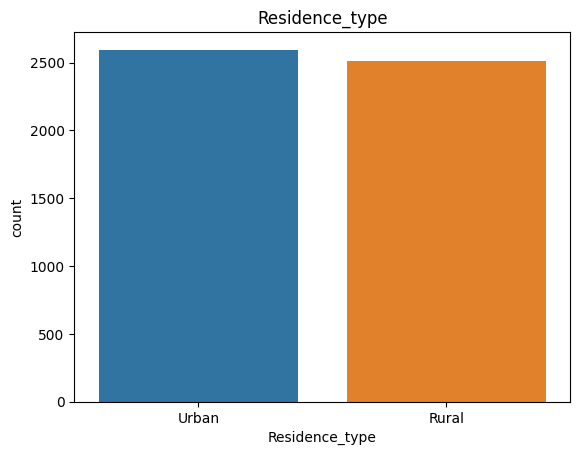

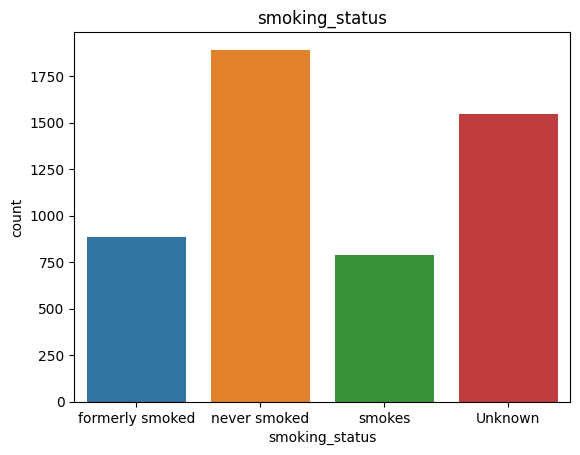

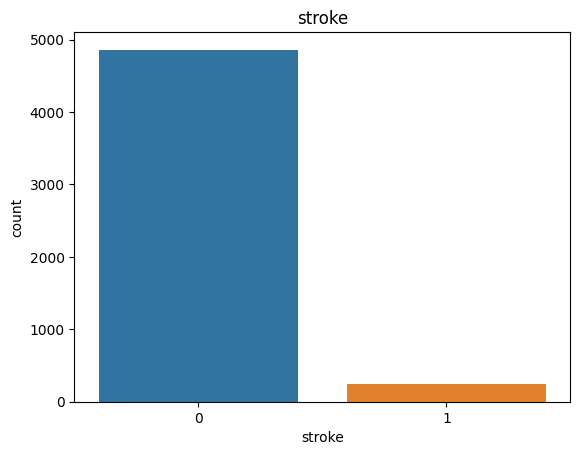

In [15]:
categ = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

# plotting the counplots for the categorical columns.
for k in categ:
    if k in data.columns:
        plt.show()
        sns.countplot(data = data, x = k)
        plt.title(k)

From the data above, I came up with the following insights:
* ***stroke, heart_disease*** and ***hypertension*** columns are highly imbalanced. 
* The ***Other gender*** has very few individuals, thus the need to drop the info about these individuals.
* Most individual were/ had been married.
* The ***Unknown*** category in the ***smoking status*** column were quite many, indicating their data was unavailable.
* The ***never_worked*** category in the ***work_type*** column were quite few.

In [16]:
# getting the value counts of the gender column.
data['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [17]:
# getting the value counts in the work_type category
data['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

I have decided to drop the ***Never_worked*** work_type individuals and the ***Other gender***

In [18]:
# dropping 'Other' gender.
data.drop(data.loc[data['gender']=='Other'].index, inplace=True)

# dropping the 'Never_worked' category.

data.drop(data.loc[data['work_type']== 'Never_worked'].index, inplace=True)

### 2. Bivariate EDA


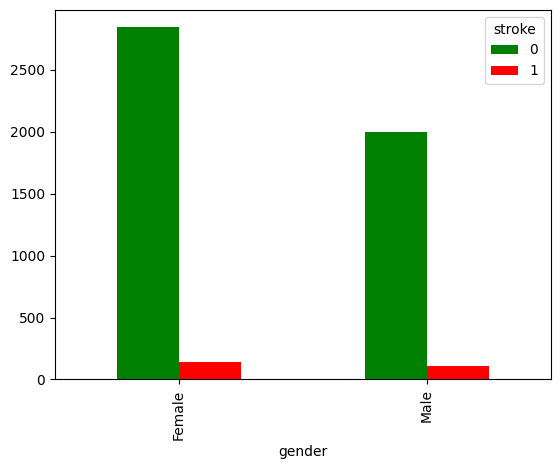

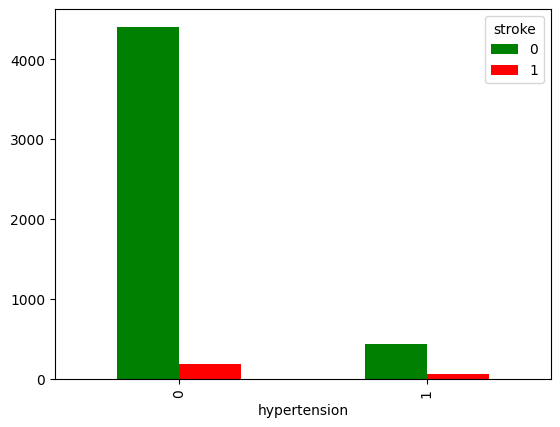

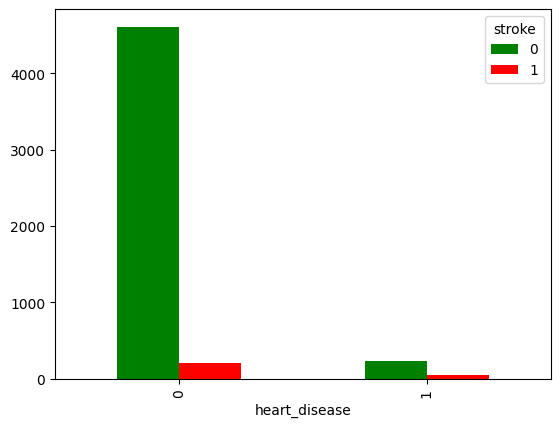

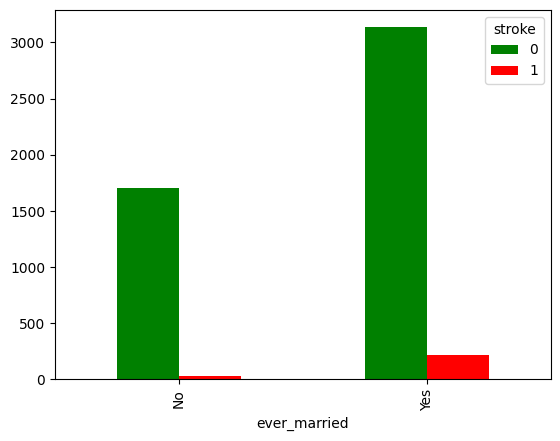

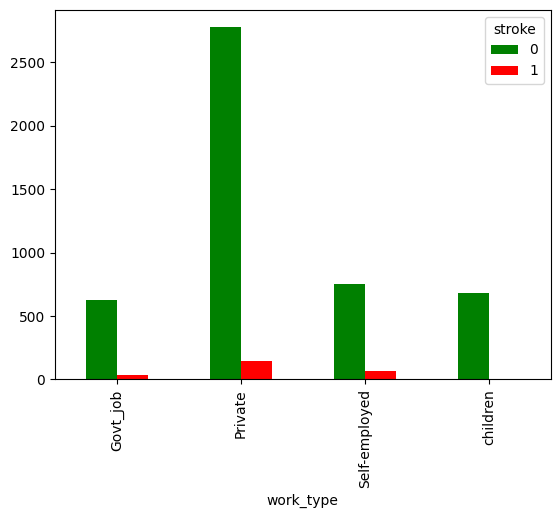

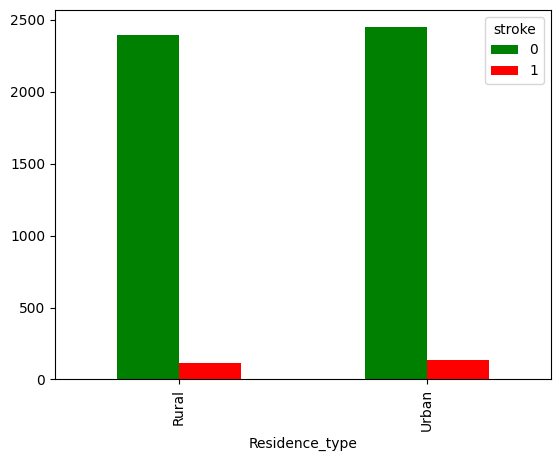

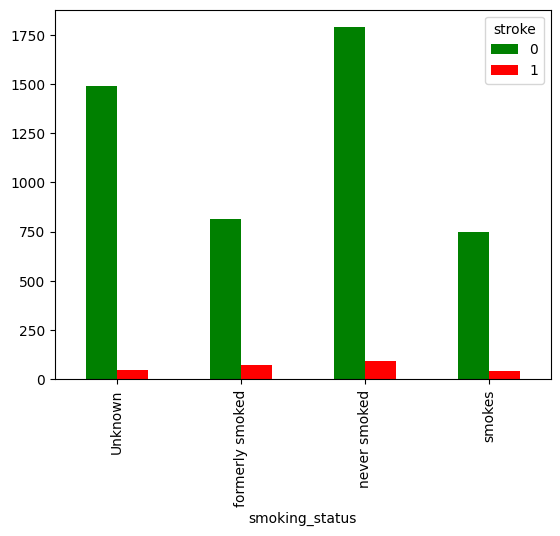

In [19]:
# checking the relationship between categorical columns and stroke. 

categ = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for c in categ:
    if c in data.columns:
        plt.show()
        pd.crosstab(data[c],data.stroke).plot(kind='bar', color=['green', 'red'])

I observed the following from the data:
* Males seemed to be at a higher risk to have stroke.
* Those who smoke and former smoker are at a higher risk to have stroke.
* Those with heart disease and hypertension are also at a higher risk of being diabetic.

Text(0, 0.5, 'BMI')

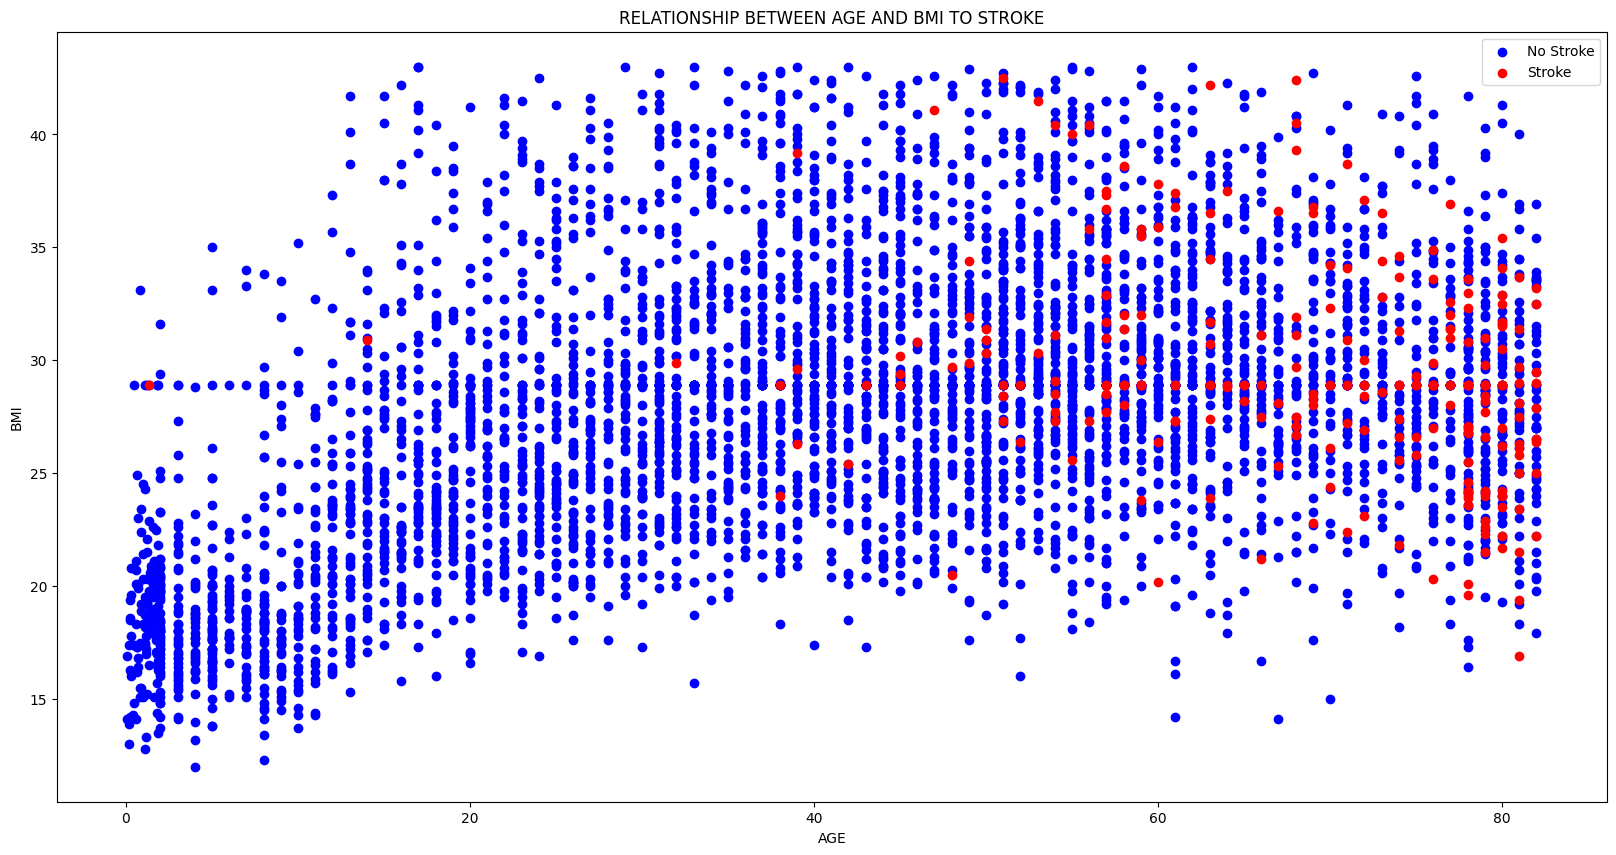

In [20]:
# investigating the chances of one having stroke based on age and bmi.

plt.figure(figsize=(20,10))

# ploting for those without stroke

plt.scatter(data.age[data.stroke == 0],
            data.bmi[data.stroke == 0],
            color = 'blue'
            )

# ploting for those with stroke
plt.scatter(
    data.age[data.stroke == 1],
    data.bmi[data.stroke == 1],
    color=['red']
)

plt.title('RELATIONSHIP BETWEEN AGE AND BMI TO STROKE')
plt.legend(['No Stroke', 'Stroke'])
plt.xlabel('AGE')
plt.ylabel('BMI')

From the above, it is clear that individual above the age of 40 are at a higher risk of having stroke compared to younger people.

Text(0, 0.5, 'AVERAGE GLUCOSE LEVEL')

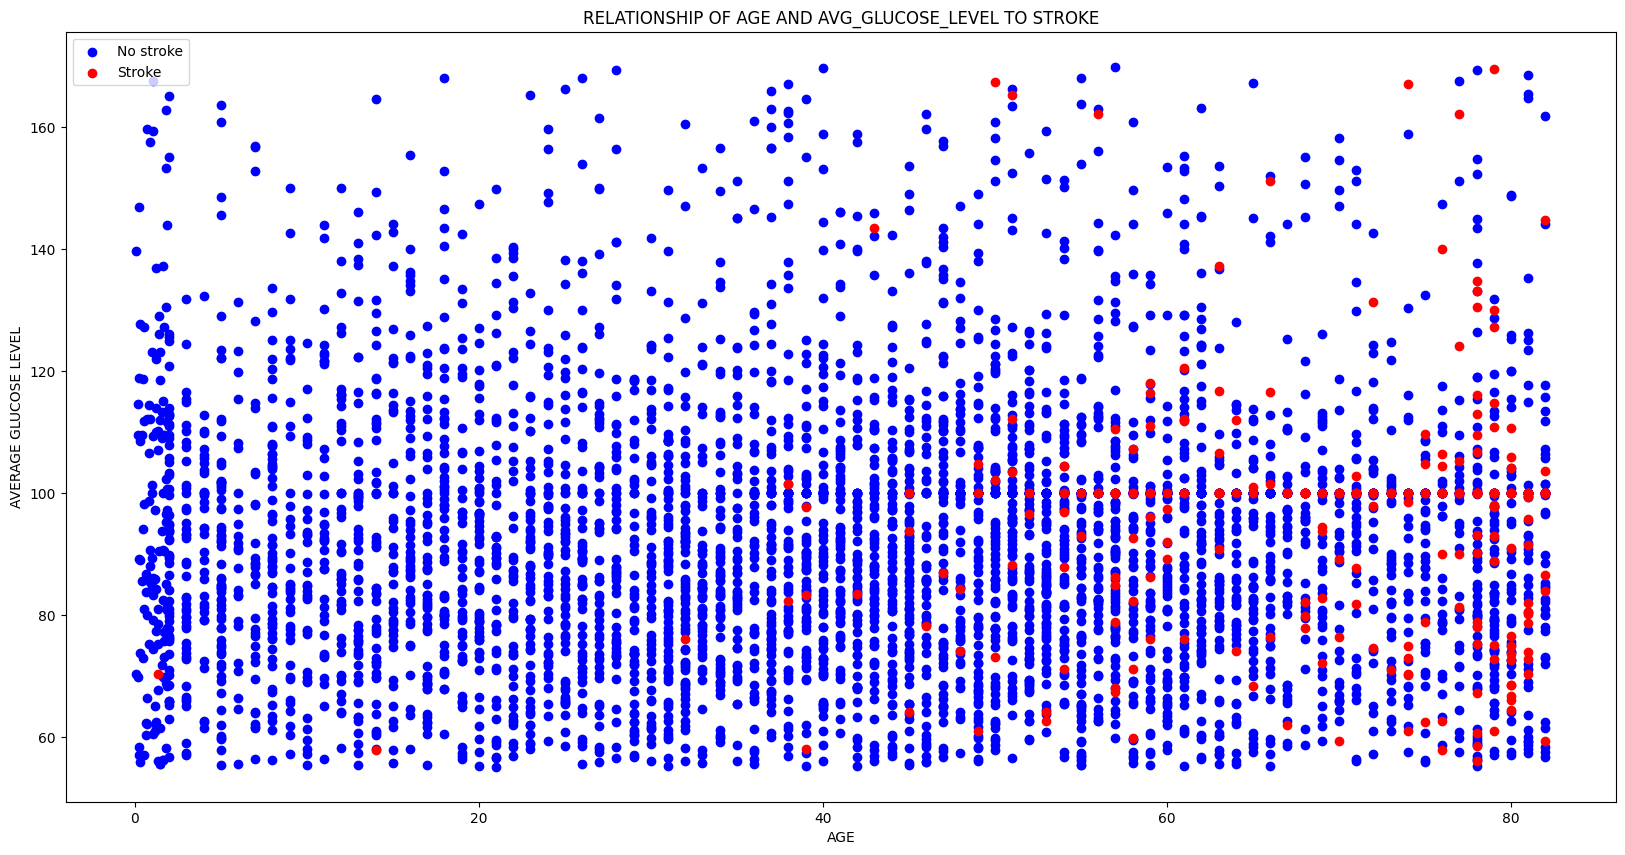

In [21]:
# investigating tthe relationship between age and avg_glucose_level to STROKE.

plt.figure(figsize=(20,10))

# plotting for those without stroke.
plt.scatter(
    data.age[data.stroke==0],
    data.avg_glucose_level[data.stroke == 0],
    color = ['blue']
)

# plotting for those with stroke

plt.scatter(data.age[data.stroke==1],
            data.avg_glucose_level[data.stroke==1], 
            color=['red'])


plt.title('RELATIONSHIP OF AGE AND AVG_GLUCOSE_LEVEL TO STROKE')
plt.legend(['No stroke', 'Stroke'])
plt.xlabel('AGE')
plt.ylabel('AVERAGE GLUCOSE LEVEL')

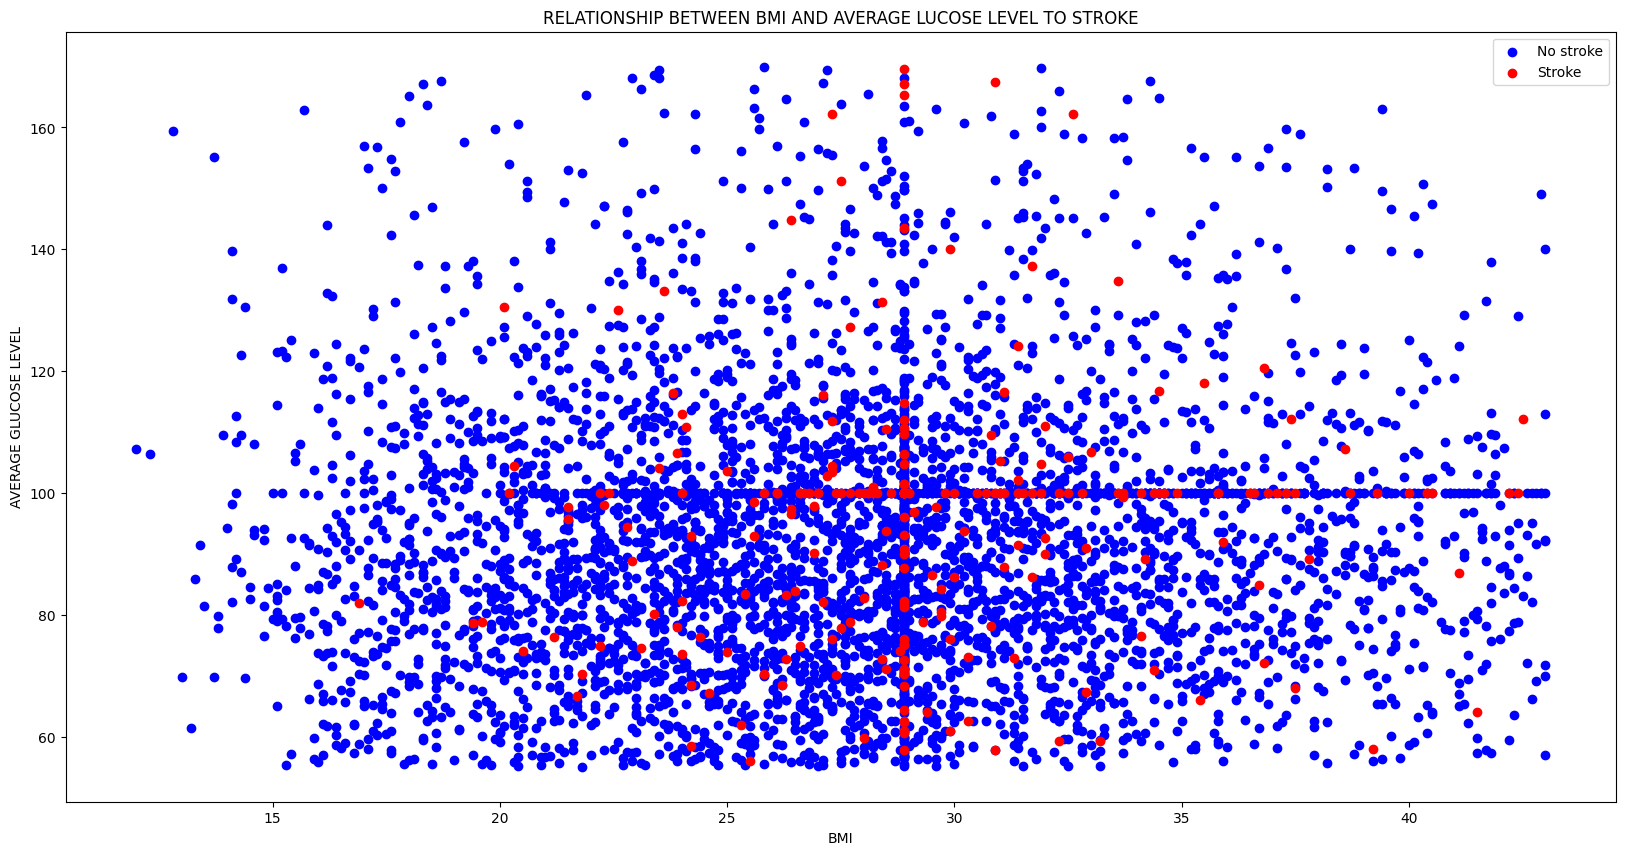

In [22]:
# relationship between BMI and AVG_GLUCOSE_LEVEL to STROKE.

plt.figure(figsize=(20,10))

# plotting for those without stroke
plt.scatter(
    data.bmi[data.stroke==0],
    data.avg_glucose_level[data.stroke==0],
    color = ['blue']
)

# plotting for those with stroke
plt.scatter(
    data.bmi[data.stroke == 1],
    data.avg_glucose_level[data.stroke == 1],
    color=['red']
)

plt.title('RELATIONSHIP BETWEEN BMI AND AVERAGE LUCOSE LEVEL TO STROKE')
plt.xlabel('BMI')
plt.ylabel('AVERAGE GLUCOSE LEVEL')
plt.legend(['No stroke', 'Stroke'])

From the scatterplots, there does not seem to be any effect on ones health from the attributes, except from age where older people are at  a higher risk of having stroke.

# FEATURE ENGINEERING AND SELECTION.

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5087 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5087 non-null   int64  
 1   gender             5087 non-null   object 
 2   age                5087 non-null   float64
 3   hypertension       5087 non-null   int64  
 4   heart_disease      5087 non-null   int64  
 5   ever_married       5087 non-null   object 
 6   work_type          5087 non-null   object 
 7   Residence_type     5087 non-null   object 
 8   avg_glucose_level  5087 non-null   float64
 9   bmi                5087 non-null   float64
 10  smoking_status     5087 non-null   object 
 11  stroke             5087 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 516.6+ KB


In [24]:
data.drop(['id'], axis=1, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,100.013839,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,100.013839,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.920000,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,100.013839,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,100.013839,24.000000,never smoked,1


In [25]:
data.nunique()

gender                  2
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               4
Residence_type          2
avg_glucose_level    3367
bmi                   303
smoking_status          4
stroke                  2
dtype: int64

In [26]:
# Using LabelEncoder in ['gender', 'ever_married' 'Residence_type'] columns to convert them to numerical format.

c = ['gender', 'ever_married', 'Residence_type']

le =LabelEncoder()

for k in c:
    if k in data.columns:
        data[k] = le.fit_transform(data[k])

data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,1,100.013839,36.600000,formerly smoked,1
1,0,61.0,0,0,1,Self-employed,0,100.013839,28.893237,never smoked,1
2,1,80.0,0,1,1,Private,0,105.920000,32.500000,never smoked,1
3,0,49.0,0,0,1,Private,1,100.013839,34.400000,smokes,1
4,0,79.0,1,0,1,Self-employed,0,100.013839,24.000000,never smoked,1


In [27]:
# using oneHotEncoding to convert ['work_type' , 'smoking_status'] to numerical format.

data = pd.get_dummies(data.work_type)\
        .join(data['age'])\
        .join(data['gender'])\
        .join(data['hypertension'])\
        .join(data['heart_disease'])\
        .join(data['ever_married'])\
        .join(data['Residence_type'])\
        .join(data['avg_glucose_level'])\
        .join(data['bmi'])\
        .join(pd.get_dummies(data['smoking_status']))\
        .join(data['stroke'])

data.head()

,Govt_job,Private,Self-employed,children,age,gender,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,Unknown,formerly smoked,never smoked,smokes,stroke
0,0,1,0,0,67.0,1,0,1,1,1,100.013839,36.600000,0,1,0,0,1
1,0,0,1,0,61.0,0,0,0,1,0,100.013839,28.893237,0,0,1,0,1
2,0,1,0,0,80.0,1,0,1,1,0,105.920000,32.500000,0,0,1,0,1
3,0,1,0,0,49.0,0,0,0,1,1,100.013839,34.400000,0,0,0,1,1
4,0,0,1,0,79.0,0,1,0,1,0,100.013839,24.000000,0,0,1,0,1


<AxesSubplot: >

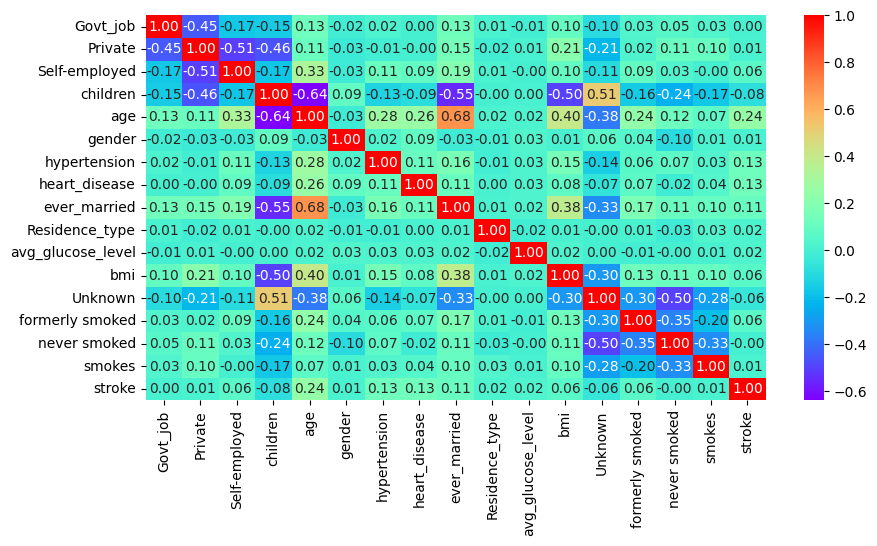

In [34]:
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True, cmap='rainbow', fmt='.2f')

If I consider correlation as a feature selection technique, I would have gotten rid of quite a good number of columns such as:
* Govt_job
* Private
* self_employed
* children
* gender, etc.

In [37]:
data.var().sort_values(ascending=False)

age                  510.384812
avg_glucose_level    461.306148
bmi                   36.869330
Residence_type         0.249995
Private                0.244453
gender                 0.242583
never smoked           0.232931
ever_married           0.224721
Unknown                0.210816
formerly smoked        0.143606
Self-employed          0.135105
smokes                 0.131071
children               0.116835
Govt_job               0.112494
hypertension           0.088330
heart_disease          0.051322
stroke                 0.046562
dtype: float64

Considering Variance, I would have dropped:
* heart_disease
* hypetension
* Govt_job
* Children

I will drop the ['Govt_job' and 'children'] columns in a later exercise and compare the accuracies.

In [40]:
X = data.drop(['stroke'], axis=1)
y = data['stroke']

### NORMALIZATION.

In [43]:
# using standard scaler for normalization of data.
scaler = StandardScaler()

X = scaler.fit_transform(X)



# TRAINING THE MODEL


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.5, random_state=0)

In [45]:
# creating a dictionary of different classifiers.

c = 10

classifiers = {
    # applying linear svc in the model prediction.
    'Linear SVC': SVC(kernel='linear', C=c, probability=True, random_state=0 ),
    # applying KNeighboursClassifier.
    'KNN Classifier': KNeighborsClassifier(n_neighbors=4),
    # applying Support-Vector Machine
    'SVC': SVC(),
    # applying AdaBoostClassifier
    'ADA': AdaBoostClassifier(n_estimators=100),
    #applying RandomForestClassifier
    'RFST': RandomForestClassifier(n_estimators=100),
    # applying XGBClassifier
    'XGBClassifier':XGBClassifier(min_child_weight=1, gamma=1, subsample=0.8, max_depth=5),
    #Using CatBoostClassifier()
    'CATBOOST CLASSIFIER':CatBoostClassifier() 

}


In [48]:
for index,(name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print('Accuracy (train) for %s: %0.1f%%' % (name, accuracy*100))
    print(classification_report(y_test, y_pred))

Accuracy (train) for Linear SVC: 95.2%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2422
           1       0.00      0.00      0.00       122

    accuracy                           0.95      2544
   macro avg       0.48      0.50      0.49      2544
weighted avg       0.91      0.95      0.93      2544



C:\Users\muhum\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muhum\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muhum\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy (train) for KNN Classifier: 95.0%
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2422
           1       0.17      0.01      0.02       122

    accuracy                           0.95      2544
   macro avg       0.56      0.50      0.50      2544
weighted avg       0.91      0.95      0.93      2544

Accuracy (train) for SVC: 95.2%
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2422
           1       0.00      0.00      0.00       122

    accuracy                           0.95      2544
   macro avg       0.48      0.50      0.49      2544
weighted avg       0.91      0.95      0.93      2544



C:\Users\muhum\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muhum\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\muhum\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Accuracy (train) for ADA: 94.8%
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2422
           1       0.22      0.03      0.06       122

    accuracy                           0.95      2544
   macro avg       0.59      0.51      0.52      2544
weighted avg       0.92      0.95      0.93      2544

Accuracy (train) for RFST: 95.0%
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2422
           1       0.14      0.01      0.02       122

    accuracy                           0.95      2544
   macro avg       0.55      0.50      0.49      2544
weighted avg       0.91      0.95      0.93      2544

Accuracy (train) for XGBClassifier: 94.5%
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2422
           1       0.23      0.07      0.10       122

    accuracy                           0.94      2544
   macro avg       0.